In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# Load data

In [2]:
fake = pd.read_csv("../data/raw/Fake.csv").drop('date',axis=1)#.rename(columns={"date":"date_temp"})
fake["class"]="Fake"

In [3]:
real = pd.read_csv("../data/raw/True.csv").drop('date',axis=1)#.rename(columns={"date":"date_temp"})
real["class"] = "Real"

# Little  data analysis

In [4]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
title      23481 non-null object
text       23481 non-null object
subject    23481 non-null object
class      23481 non-null object
dtypes: object(4)
memory usage: 733.9+ KB


In [5]:
fake.shape

(23481, 4)

In [6]:
fake["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [84]:
real["subject"].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [86]:
df = pd.concat([real,fake],sort=False).drop("subject",axis=1)

In [88]:
X,y = df.drop(["class"],axis=1),df["class"]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# NLP pipeline 

In [148]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import word_tokenize 
import nltk
import re
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [149]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [150]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/susannazirizadeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer,
                       strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True,
                       token_pattern = r'\b[a-zA-Z]{3,}\b', # keeps words of 3 or more characters
                       max_df = 0.5,
                       min_df = 10)

In [180]:
# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return[self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]
    
stop_words = set(stopwords.words('english')) 
# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))

In [181]:
text_features_title = 'title'
text_transformer_title = Pipeline(steps=[
    ('cnt', TfidfVectorizer(tokenizer=tokenizer,
                            analyzer='word',
                            ngram_range=(1,2),
                            max_features=100,
                            stop_words=token_stop,
                            token_pattern='[A-Za-z][\w\-]*',
                            max_df=0.25,
                            use_idf=True,
                            lowercase=True))
])


text_features_text = 'text'
text_transformer_text = Pipeline(steps=[
    ('cnt', TfidfVectorizer(tokenizer=tokenizer,
                            analyzer='word',
                            ngram_range=(1,2),
                            max_features=100,
                            stop_words=token_stop,
                            token_pattern='[A-Za-z][\w\-]*',
                            max_df=0.25,
                            use_idf=True,
                            lowercase=True))
])

preprocessor = ColumnTransformer(transformers=[
    ('txt_text', text_transformer_text, text_features_text),
    ('txt_title', text_transformer_title, text_features_title),
])

estimators = [('preprocessor', preprocessor),
              ('classifier', LogisticRegression(C=1, penalty='l2'))]
pipe = Pipeline(estimators)


pipe.fit(X_train, y_train)
print("model score: %.3f" % pipe.score(X_test, y_test))

/Users/susannazirizadeh/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


model score: 0.982


In [182]:
y_pred = pipe.predict(X_test)

In [183]:
cf_matrix = confusion_matrix(y_test, y_pred)

In [184]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      7867
        Real       0.98      0.98      0.98      6950

    accuracy                           0.98     14817
   macro avg       0.98      0.98      0.98     14817
weighted avg       0.98      0.98      0.98     14817



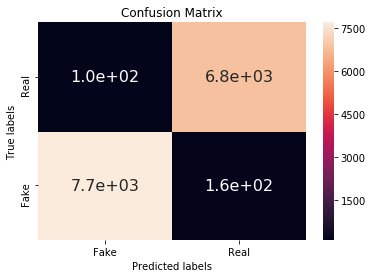

In [185]:
ax = sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 16})
ax.set_ylim([0,2]);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);


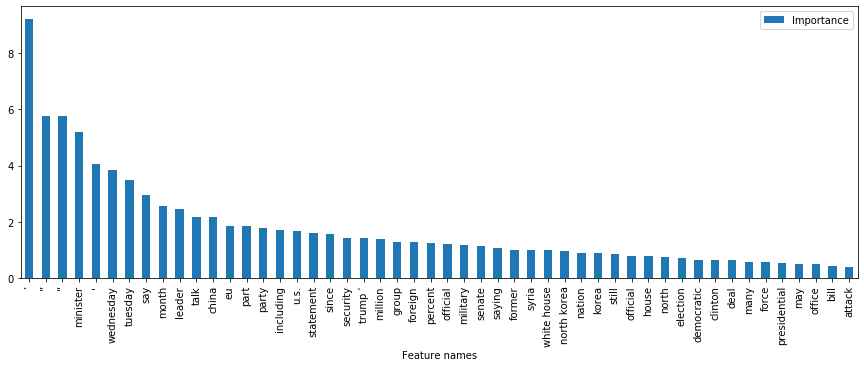

In [186]:
pre1 = (pipe.named_steps['preprocessor']
         .named_transformers_['txt_text']
         .named_steps['cnt'])

pre2 = (pipe.named_steps['preprocessor']
         .named_transformers_['txt_title']
         .named_steps['cnt'])

feature_names1 = pre1.get_feature_names()
feature_names2 = pre2.get_feature_names()

feature_names = np.r_[feature_names1, feature_names2]


feature_importances = (
    pipe.named_steps['classifier'].coef_)

feature_imp = pd.DataFrame({"Feature names": feature_names, "Importance": feature_importances[0]}).sort_values(by=["Importance"],ascending= False)
feature_imp[:50].plot.bar(x="Feature names",y="Importance",figsize=[15,5])

In [ ]:
param_grid = {
    'preprocessor__txt_text__cnt__max_features': [1000, 1500, 2000],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(pipe, param_grid, cv=10)
grid_search.fit(X_train, y_train)

print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))